<center><h1>Deep learing project no.1</h1></center>

<h3>Authors:</h3>
<p>Marek Szydłowski 136633 <br/>
Wotjek Tomczak 145467<p>

In [1]:
%matplotlib inline
import os
import fnmatch

from pathlib import Path

from IPython.display import display

import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import gdown

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, precision_recall_fscore_support
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 6]

2021-11-15 00:47:04.094219: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-15 00:47:04.094239: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<center><h1>Part 1.</h1></center>

<center><h1>Downloading the data</h1></center>

In [2]:
DATA_DIR = "data/"
DATA_PATH = DATA_DIR + "101_ObjectCategories/"
DATA_TAR = DATA_DIR + "101_ObjectCategories.tar.gz"
MODELS_PATH = "models/"

BACKGROUND_GOOGLE = DATA_PATH + "BACKGROUND_Google"


In [3]:
data_check = Path(DATA_PATH)
tar_check = Path(DATA_TAR)

!mkdir -p $DATA_DIR

if not data_check.exists() and not tar_check.exists():
    # No data exists
    gdown.download("https://drive.google.com/uc?id=194fJtjdnJUsH6qDdOmMAgnbBcHcVWwgT", DATA_DIR, False)

if tar_check.exists():
    # Extract and remove tar.gz file
    !tar -xf $DATA_TAR --directory="data"
    !rm -r $BACKGROUND_GOOGLE
    !rm $DATA_TAR


Downloading...
From: https://drive.google.com/uc?id=194fJtjdnJUsH6qDdOmMAgnbBcHcVWwgT
To: /home/marek-szyd/Projects/Python/DL_labs/data/101_ObjectCategories.tar.gz
100%|██████████| 132M/132M [00:01<00:00, 97.4MB/s]


<center><h1>Data preprocessing</h1></center>

In [4]:
# cheking size of classes in our database of choice

file_counter = []

for data_dir in Path(DATA_PATH).iterdir():
    file_counter.append(
        [
            len(fnmatch.filter(os.listdir(data_dir), "*.jpg")),
            str(data_dir).split("/")[-1],
        ]
    )

results = pd.DataFrame(
    sorted(file_counter, key=lambda x: x[0], reverse=True),
    columns=["FILE_COUNT", "CLASS_NAME"],
)

results


,FILE_COUNT,CLASS_NAME
0,800,airplanes
1,798,Motorbikes
2,435,Faces
3,435,Faces_easy
4,239,watch
...,...,...
96,34,platypus
97,34,wild_cat
98,33,binocular
99,32,metronome


In [5]:
classes = results[results["FILE_COUNT"] > 86]["CLASS_NAME"].values
max_len = np.min(results[results["FILE_COUNT"] > 86]["FILE_COUNT"])


In [6]:
classes


array(['airplanes', 'Motorbikes', 'Faces', 'Faces_easy', 'watch',
       'Leopards', 'bonsai', 'car_side', 'ketch', 'chandelier',
       'hawksbill', 'grand_piano', 'brain', 'butterfly', 'helicopter',
       'menorah'], dtype=object)

In [7]:
images = {}
for data_dir in Path(DATA_PATH).iterdir():
    if data_dir.name in classes:
        current_len = 0
        for f in data_dir.iterdir():
            if current_len == max_len:
                break

            if not f.is_file():
                continue

            current_len += 1

            if data_dir.name not in images:
                images[data_dir.name] = 1
            else:
                images[data_dir.name] += 1

df = (
    pd.DataFrame.from_dict(images, "index")
    .reset_index()
    .rename({0: "length", "index": "name"}, axis=1)
)


In [8]:
df


,name,length
0,Faces,87
1,Faces_easy,87
2,Leopards,87
3,Motorbikes,87
4,airplanes,87
5,bonsai,87
6,brain,87
7,butterfly,87
8,car_side,87
9,chandelier,87


In [9]:
dataset = []
labels = []
filenames = []

for row in df.itertuples():
    dirname = row.name
    max_len = row.length

    current_len = 0
    for filename in os.listdir(DATA_PATH + dirname):
        if current_len == max_len:
            break

        if ".jpg" not in filename:
            continue

        current_len += 1

        img = cv2.imread(DATA_PATH + dirname + "/" + filename)
        resized = cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA)

        filenames.append(dirname + "/" + filename)
        dataset.append(resized)
        labels.append(dirname)

dataset = np.array(dataset)


In [10]:
dataset.shape


(1392, 32, 32, 3)

In [11]:
bgr_mean = np.mean(dataset, axis=(0, 1, 2))
bgr_std = np.std(dataset, axis=(0, 1, 2))
bgr_mean, bgr_std


(array([127.66310488, 133.68402591, 136.24699805]),
 array([78.14648073, 73.81944396, 75.55141328]))

In [12]:
std_data = (dataset - bgr_mean) / bgr_std
std_data.shape


(1392, 32, 32, 3)

Image before standardization


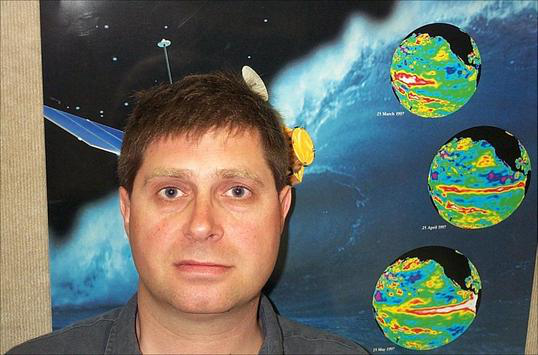

In [13]:
print("Image before standardization")
with Image.open(DATA_PATH + filenames[0]) as img:
    display(img)


In [14]:
# DO NOT CLOSE IMAGE WITH "X" ICON, JUST WAIT
# Uncoment to run


# cv2.imshow('tmp', std_data[0])
# cv2.waitKey(7000)

# cv2.destroyAllWindows()


<center><h1>Splitting data into Train and Test</h1></center>

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    std_data, labels, stratify=labels, test_size=0.3, random_state=23
)

y_train, y_test = np.array(y_train), np.array(y_test)


In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((974, 32, 32, 3), (418, 32, 32, 3), (974,), (418,))

In [17]:
def oneHotterEncoder(target):
    _target = target.reshape(-1, 1)
    encoder = OneHotEncoder(handle_unknown="ignore")
    new_target = encoder.fit(_target)
    return new_target.categories_, new_target.transform(_target).toarray()


In [18]:
classes_train, y_train_enc = oneHotterEncoder(y_train)
classes_test, y_test_enc = oneHotterEncoder(y_test)

(classes_train,) = classes_train
(classes_test,) = classes_test


<center><h1>Model definition and training</h1></center>

In [19]:
def create_and_solve_model(
    isDropout=True,
    drop_1=0.75,
    drop_2=0.65,
    activation="relu",
    isBatchNormalization=True,
    pooling=layers.MaxPool2D,
    no_conv_layers=2,
    batch_size=32,
    verbose=False,
):
    """Helper function for all experiments with tasks."""

    model = models.Sequential()

    model.add(
        layers.Conv2D(
            32,
            (3, 3),
            activation=activation,
            padding="same",
            input_shape=X_train[0].shape,
        )
    )
    model.add(pooling((2, 2)))

    for i in range(no_conv_layers):
        model.add(layers.Conv2D(64, (3, 3), activation=activation, padding="same"))
        if i != no_conv_layers - 1:
            model.add(pooling((2, 2)))

    if isBatchNormalization:
        model.add(layers.BatchNormalization())

    model.add(layers.Flatten())

    if isDropout:
        model.add(layers.Dropout(drop_1))

    model.add(layers.Dense(64))

    if isDropout:
        model.add(layers.Dropout(drop_2))

    model.add(layers.Dense(64))
    model.add(layers.Dense(len(classes), activation="softmax"))

    if verbose:
        print(f"Number of classes: {len(classes)}")
        model.summary()

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=5)

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    history = model.fit(
        X_train,
        y_train_enc,
        batch_size=batch_size,
        epochs=250,
        validation_data=(X_test, y_test_enc),
        callbacks=[early_stopping],
        use_multiprocessing=True,
        verbose=verbose
    )

    return model, history


In [20]:
def plot_model_accuracy(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(history.history["accuracy"], label="accuracy")
    ax1.plot(history.history["val_accuracy"], label="val_accuracy")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.set_title('Accuracy')
    ax1.set_ylim([0.5, 1])
    ax1.legend(loc="lower right")
    
    ax2.plot(history.history["loss"], label="loss")
    ax2.plot(history.history["val_loss"], label="val_loss")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.set_title('Loss')
    ax2.legend(loc="lower right")
    
    fig.suptitle('Model accuracy and loss')
    plt.show()

In [21]:
def display_confusion_matrix(model):
    y_pred = np.argmax(model.predict(X_test), axis=1)

    tmp = []
    for item in y_test:
        tmp.append(np.where(classes_test == item))

    y_true = np.array(tmp).reshape(y_pred.shape)

    prec, rec, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    for ind in range(len(prec)):
        print(
            f"Class {ind}:\tPrecision: {round(prec[ind], 3):<10}"
            f"Recall: {round(rec[ind], 3):<10}"
            f"F-score: {round(fscore[ind], 3):<10}"
        )

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    _ = disp.plot()



In [22]:
def print_test_accuracy(model):
    test_loss, test_acc = model.evaluate(X_test, y_test_enc, verbose=2)

    print(f"Test accuracy: {round(test_acc * 100, 3)}%\n")

In [23]:
model, history = create_and_solve_model(verbose=True)

2021-11-15 00:47:13.654672: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 00:47:13.655160: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/marek-szyd/Programs/anaconda3/envs/dl/lib/python3.8/site-packages/cv2/../../lib64:
2021-11-15 00:47:13.655253: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/marek-szyd/Programs/anaconda3/envs/dl/lib/python3.8/site-packages/cv2/../../lib64:
2021-11-15 00:47:13.655331: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dyn

Number of classes: 16
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 batch_normalization (BatchN  (Non

14/14 - 0s - loss: 0.9800 - accuracy: 0.8038 - 57ms/epoch - 4ms/step
Test accuracy: 80.383%

Class 0:	Precision: 0.833     Recall: 0.962     F-score: 0.893     
Class 1:	Precision: 1.0       Recall: 1.0       F-score: 1.0       
Class 2:	Precision: 1.0       Recall: 1.0       F-score: 1.0       
Class 3:	Precision: 0.958     Recall: 0.852     F-score: 0.902     
Class 4:	Precision: 0.92      Recall: 0.885     F-score: 0.902     
Class 5:	Precision: 1.0       Recall: 0.462     F-score: 0.632     
Class 6:	Precision: 0.632     Recall: 0.889     F-score: 0.738     
Class 7:	Precision: 0.537     Recall: 0.846     F-score: 0.657     
Class 8:	Precision: 1.0       Recall: 0.885     F-score: 0.939     
Class 9:	Precision: 0.559     Recall: 0.731     F-score: 0.633     
Class 10:	Precision: 0.909     Recall: 0.769     F-score: 0.833     
Class 11:	Precision: 0.737     Recall: 0.538     F-score: 0.622     
Class 12:	Precision: 0.727     Recall: 0.615     F-score: 0.667     
Class 13:	Precision:

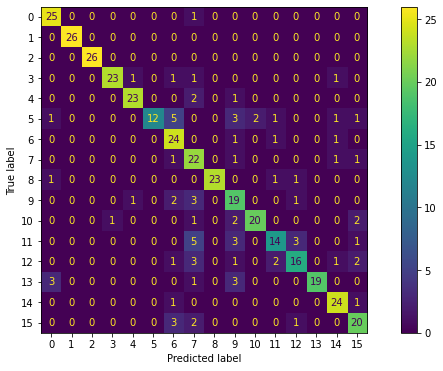

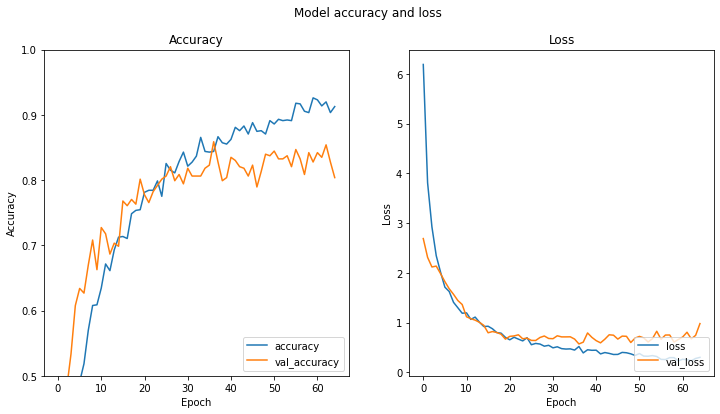

In [24]:
print_test_accuracy(model)
display_confusion_matrix(model)
plot_model_accuracy(history)

<center><h1>Saving model</h1></center>

In [25]:
def save_model(model, fname="model"):
    model.save(MODELS_PATH + fname)


def load_model(fname="model"):
    return tf.keras.models.load_model(MODELS_PATH + fname)


In [26]:
!mkdir -p $MODELS_PATH 

model.save(MODELS_PATH + "model")

2021-11-15 00:47:47.039129: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/model/assets


In [27]:
model_loaded = load_model()


In [28]:
# Predictions on loaded model
predicted = np.argmax(model_loaded.predict(X_test), axis=1)
print(f'Prediction on loaded model: {round((np.count_nonzero(y_test == classes_test[predicted]) / y_test.size) * 100, 3)}')

Prediction on loaded model: 80.383


In [29]:
model_loaded.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 64)         2

<center><h1>Summary</h1></center>

Summary

In [30]:
# Code


<center><h1>Part 2.</h1></center>

<center><h3>Task 3.</h3></center>

No dropouts:
14/14 - 0s - loss: 0.7036 - accuracy: 0.7967 - 46ms/epoch - 3ms/step
Test accuracy: 79.665%



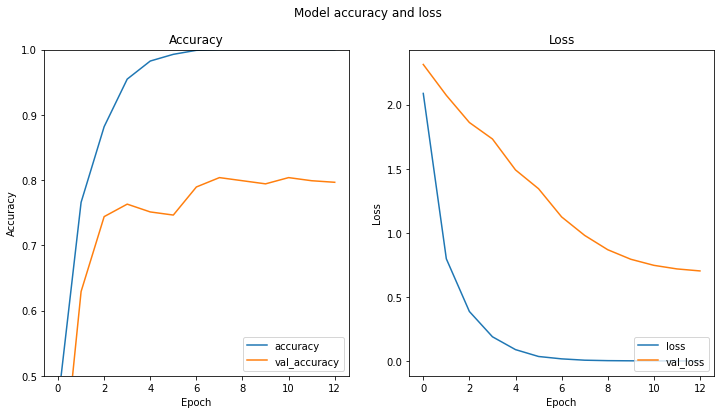



Model with dropout rates: 0.1
14/14 - 0s - loss: 0.9369 - accuracy: 0.7584 - 42ms/epoch - 3ms/step
Test accuracy: 75.837%



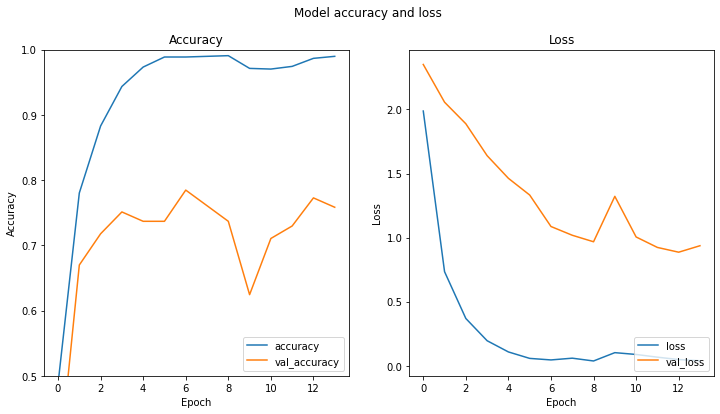



Model with dropout rates: 0.4
14/14 - 0s - loss: 1.1208 - accuracy: 0.8014 - 50ms/epoch - 4ms/step
Test accuracy: 80.144%



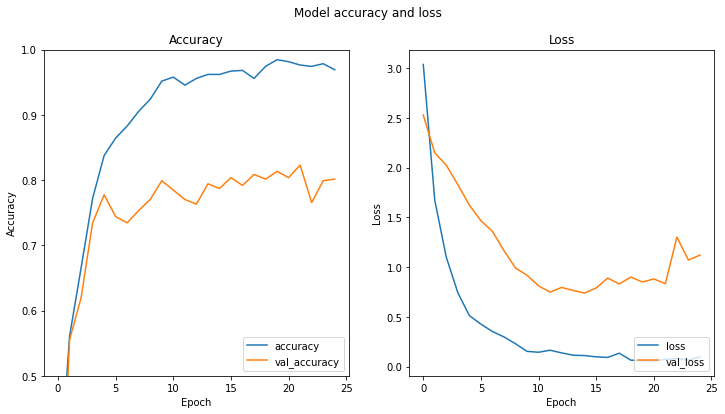



Model with dropout rates: 0.8
14/14 - 0s - loss: 0.7070 - accuracy: 0.7967 - 48ms/epoch - 3ms/step
Test accuracy: 79.665%



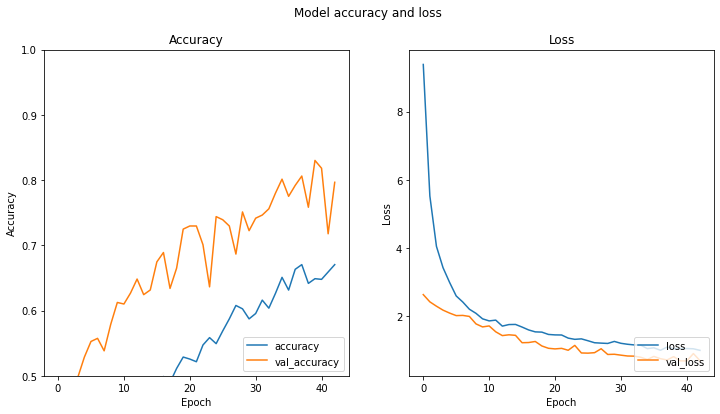

In [31]:
model_no_drop, history_no_drop = create_and_solve_model(isDropout=False)

print("No dropouts:")
print_test_accuracy(model_no_drop)
plot_model_accuracy(history_no_drop)
print("\n")

for drop in [0.1, 0.4, 0.8]:
    model_drop, history_drop = create_and_solve_model(drop_1=drop, drop_2=drop)

    print(f"Model with dropout rates: {drop}")
    print_test_accuracy(model_drop)
    plot_model_accuracy(history_drop)
    print("\n")


<center><h3>Task 5.</h3></center>

With batch normalization:
14/14 - 0s - loss: 0.9800 - accuracy: 0.8038 - 44ms/epoch - 3ms/step
Test accuracy: 80.383%



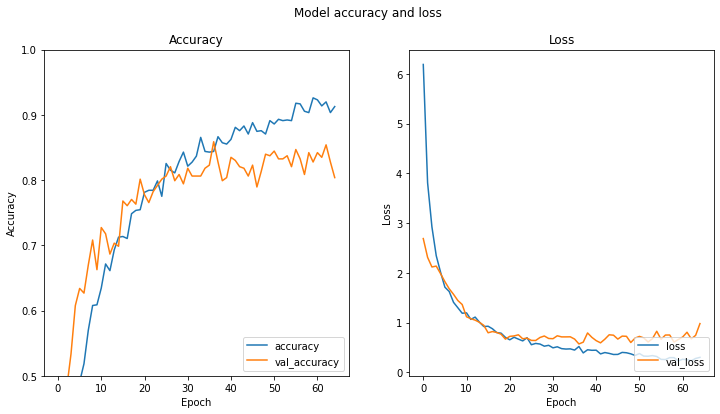



No batch normalization:
14/14 - 0s - loss: 0.6234 - accuracy: 0.8206 - 47ms/epoch - 3ms/step
Test accuracy: 82.057%



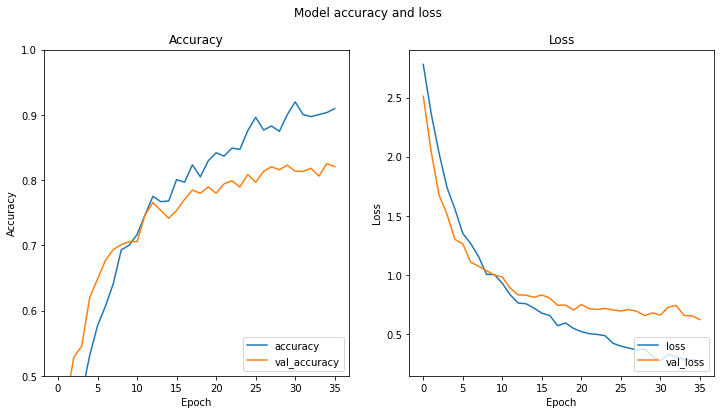

In [32]:
model_no_batch, history_no_batch = create_and_solve_model(isBatchNormalization=False)

print("With batch normalization:")
print_test_accuracy(model)
plot_model_accuracy(history)
print("\n")

print("No batch normalization:")
print_test_accuracy(model_no_batch)
plot_model_accuracy(history_no_batch)
print("\n")


<center><h3>Task 7.</h3></center>

With ReLU activation:
14/14 - 0s - loss: 0.9800 - accuracy: 0.8038 - 60ms/epoch - 4ms/step
Test accuracy: 80.383%



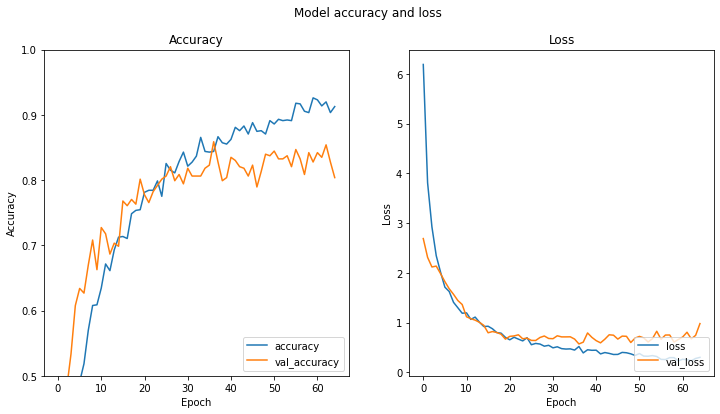



With tanh activation:
14/14 - 0s - loss: 0.6230 - accuracy: 0.8445 - 44ms/epoch - 3ms/step
Test accuracy: 84.45%



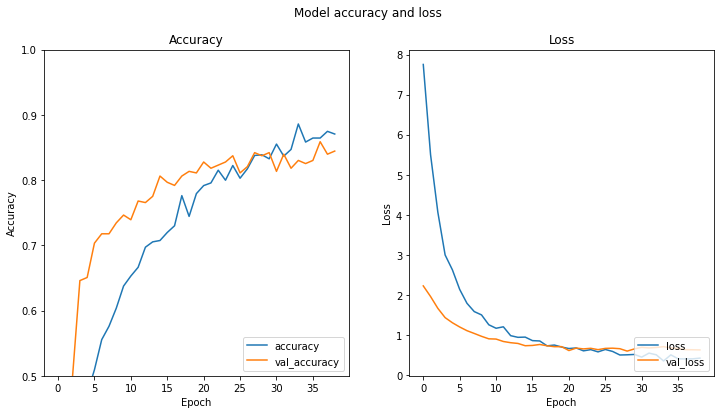



With sigmoid activation:
14/14 - 0s - loss: 0.6737 - accuracy: 0.8158 - 44ms/epoch - 3ms/step
Test accuracy: 81.579%



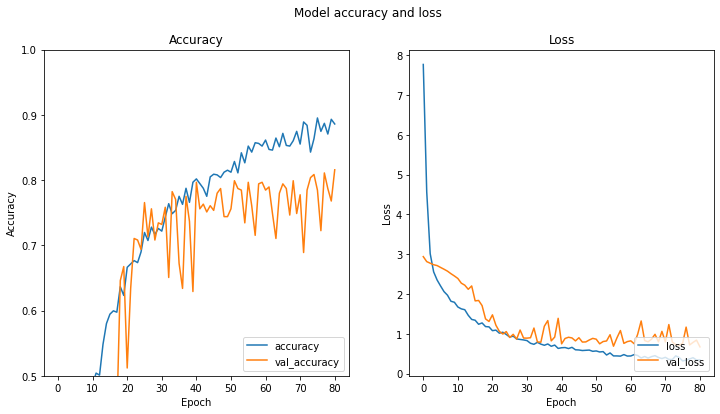



With leaky ReLU activation:
14/14 - 0s - loss: 0.6762 - accuracy: 0.8612 - 49ms/epoch - 3ms/step
Test accuracy: 86.124%



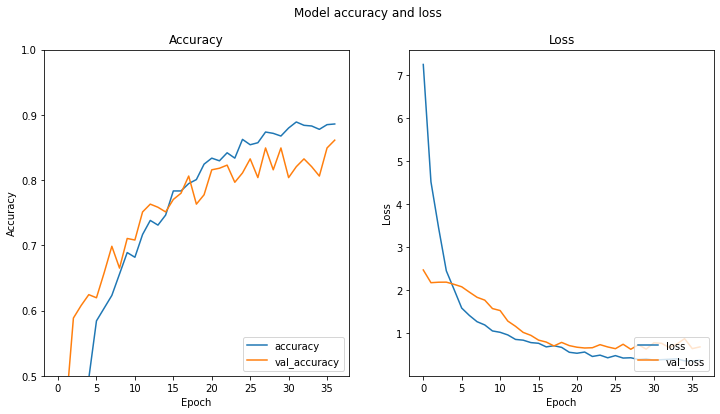

In [33]:
print("With ReLU activation:")
print_test_accuracy(model)
plot_model_accuracy(history)
print("\n")

model_tanh, history_tanh = create_and_solve_model(activation="tanh")
print("With tanh activation:")
print_test_accuracy(model_tanh)
plot_model_accuracy(history_tanh)
print("\n")

model_sigmoid, history_sigmoid = create_and_solve_model(activation="sigmoid")
print("With sigmoid activation:")
print_test_accuracy(model_sigmoid)
plot_model_accuracy(history_sigmoid)
print("\n")

model_leaky, history_leaky = create_and_solve_model(activation="leaky_relu")
print("With leaky ReLU activation:")
print_test_accuracy(model_leaky)
plot_model_accuracy(history_leaky)
print("\n")

<center><h3>Task 8.</h3></center>

With MaxPool2D:
14/14 - 0s - loss: 0.9800 - accuracy: 0.8038 - 56ms/epoch - 4ms/step
Test accuracy: 80.383%



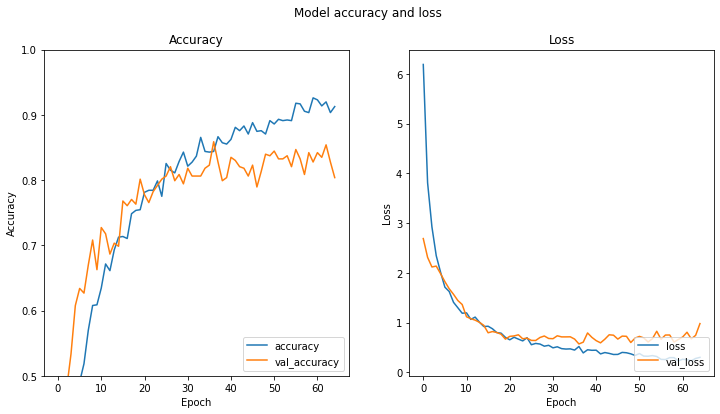



With AveragePooling2D:
14/14 - 0s - loss: 0.6504 - accuracy: 0.7847 - 47ms/epoch - 3ms/step
Test accuracy: 78.469%



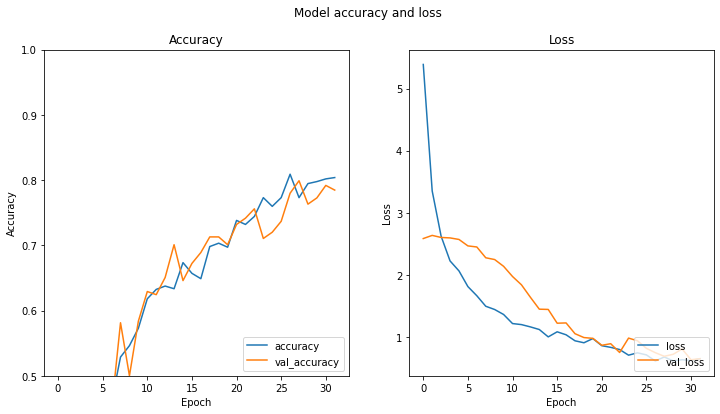

In [34]:
# Code
print("With MaxPool2D:")
print_test_accuracy(model)
plot_model_accuracy(history)
print("\n")

model_AveragePooling2D, history_AveragePooling2D = create_and_solve_model(pooling=layers.AveragePooling2D)
print("With AveragePooling2D:")
print_test_accuracy(model_AveragePooling2D)
plot_model_accuracy(history_AveragePooling2D)
print("\n")

<center><h3>Task 9.</h3></center>

With 2 convolutional layers:
14/14 - 0s - loss: 0.7119 - accuracy: 0.8158 - 47ms/epoch - 3ms/step
Test accuracy: 81.579%



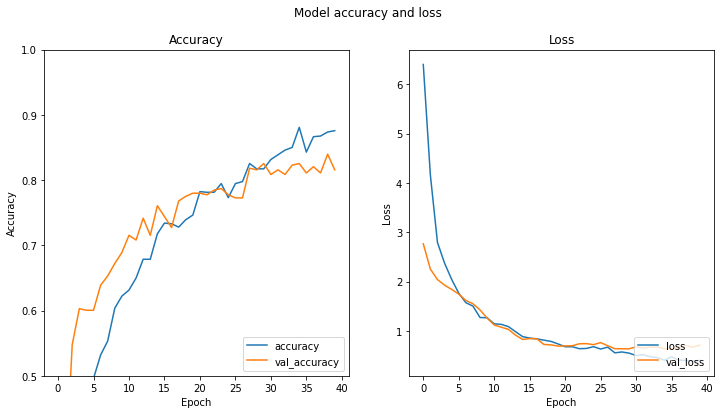



With 3 convolutional layers:
14/14 - 0s - loss: 0.9028 - accuracy: 0.7990 - 46ms/epoch - 3ms/step
Test accuracy: 79.904%



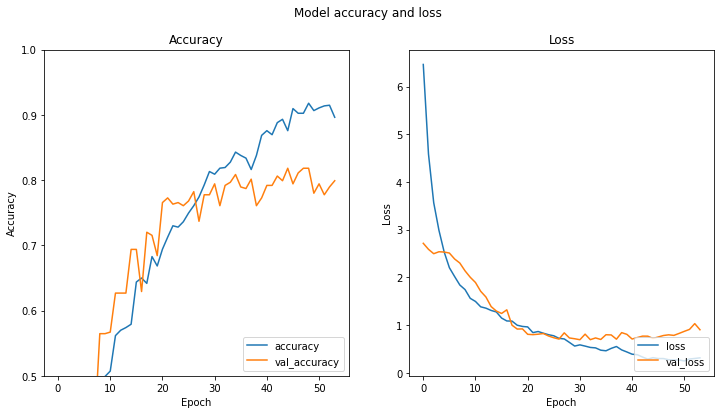



With 4 convolutional layers:
14/14 - 0s - loss: 1.6720 - accuracy: 0.7153 - 48ms/epoch - 3ms/step
Test accuracy: 71.531%



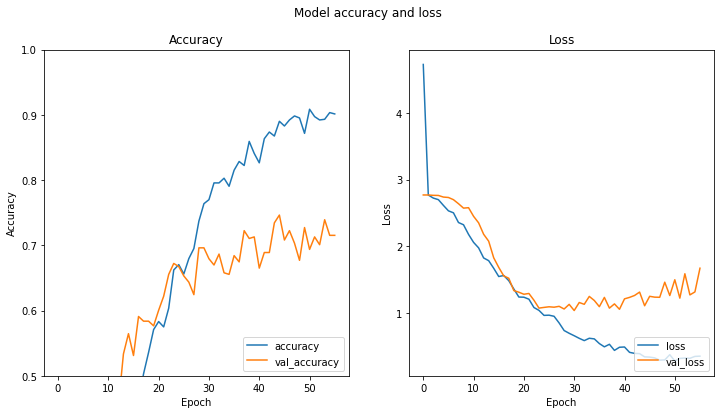

In [35]:
for no_layers in range(2, 5):
    model_n, history_n = create_and_solve_model(no_conv_layers=no_layers)
    
    print(f"With {no_layers} convolutional layers:")
    print_test_accuracy(model_n)
    plot_model_accuracy(history_n)
    print("\n")

<center><h3>Task 11.</h3></center>

With batch size 1:
14/14 - 0s - loss: 0.6700 - accuracy: 0.8206 - 128ms/epoch - 9ms/step
Test accuracy: 82.057%



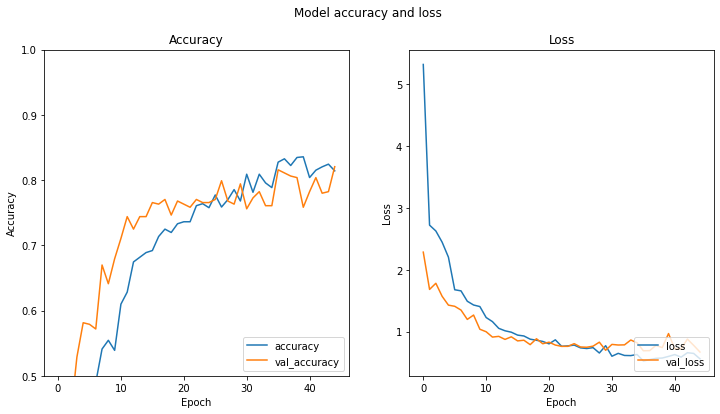



With batch size 8:
14/14 - 0s - loss: 0.6946 - accuracy: 0.8254 - 46ms/epoch - 3ms/step
Test accuracy: 82.536%



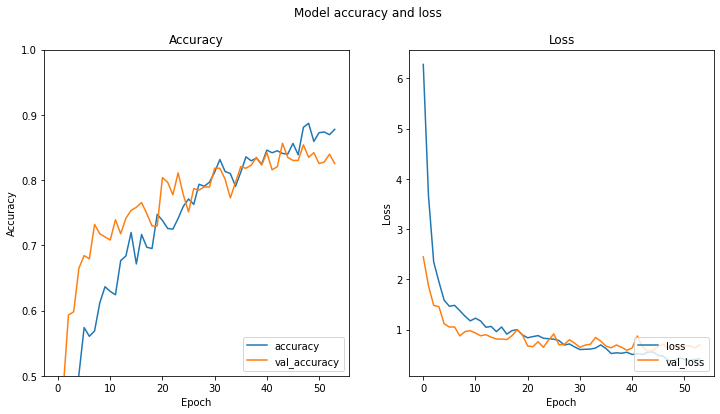



With batch size 64:
14/14 - 0s - loss: 0.5685 - accuracy: 0.8445 - 46ms/epoch - 3ms/step
Test accuracy: 84.45%



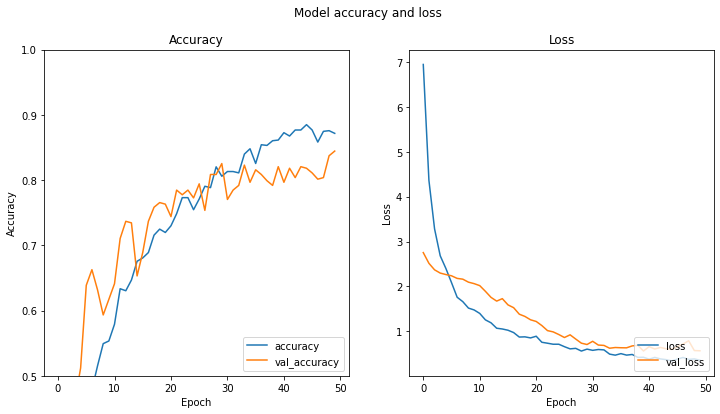



With batch size 128:
14/14 - 0s - loss: 0.5641 - accuracy: 0.8493 - 50ms/epoch - 4ms/step
Test accuracy: 84.928%



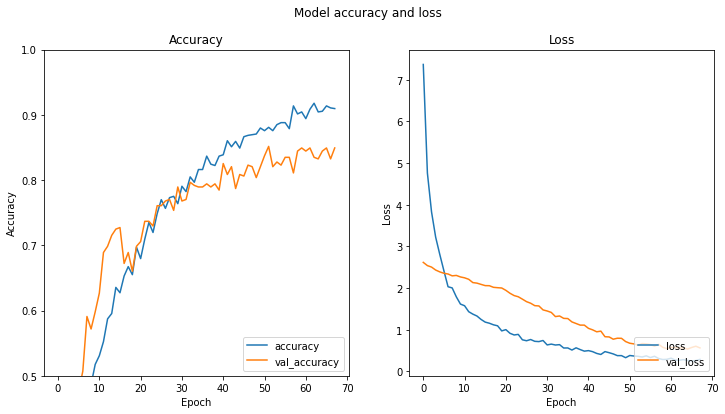

In [36]:
for batch_size in [1, 8, 64, 128]:
    model_batch, history_batch = create_and_solve_model(batch_size=batch_size)
    
    print(f"With batch size {batch_size}:")
    print_test_accuracy(model_batch)
    plot_model_accuracy(history_batch)
    print("\n")